In [123]:
import os
import datetime as dt

import IPython
import IPython.display

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import quandl
API='ev8wgXS3LGQgZuHp6Bvm'
quandl.ApiConfig.api_key = API

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation,Dropout,Dense,LSTM,BatchNormalization,Input,Bidirectional
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

<AxesSubplot:xlabel='Date'>

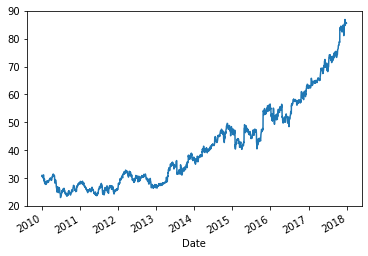

In [97]:
stock=quandl.get('WIKI/MSFT',start_date="2010-01-01",end_date="2018-01-01")
stock["Close"].plot()

In [195]:
class Ts_dataset():
  def __init__(self, data, target='Close',scale=True,shift=1,window=20,test_size=0.2):
    #Store the raw data.    
    self.split=int(len(data)*(1-test_size))
    
    #self.cols=list(data.columns)
    #self.target_col=data.columns.get_loc(target)
    self.shift = shift
    self.window=window
      
    self.train_dates=data.iloc[:self.split].index
    self.test_dates=data.iloc[self.split:].index
       
    self.Train = np.array(data.iloc[:self.split]).reshape(-1,1)
    self.Test = np.array(data.iloc[self.split:]).reshape(-1,1)

    if scale==True:
      self.Scaler=MinMaxScaler(feature_range = (0, 1))
      self.Scaler=self.Scaler.fit(self.Train)
    
      self.Train=self.Scaler.transform(self.Train)
      self.Test=self.Scaler.transform(self.Test)
    else:
      self.Train=np.array(self.Train)
      self.Test=np.array(self.Test)  
     
    self.X_train=tf.convert_to_tensor(np.array([self.Train[i-self.window:i] for i in range(self.window,len(self.Train)-self.shift+1)]))
    self.X_test=tf.convert_to_tensor(np.array([self.Test[i-self.window:i] for i in range(self.window,len(self.Test)-self.shift+1)]))
    
    self.y_train=np.array([self.Train[i+self.shift-1:i+self.shift] for i in range(self.window,len(self.Train)-self.shift+1)])
    self.y_test=np.array([self.Test[i+self.shift-1:i+self.shift]  for i in range(self.window,len(self.Test)-self.shift+1)])
    
    print(self.__repr__())

  def __repr__(self):
    return '\n'.join([
    f'Original train and test{self.Train.shape,self.Test.shape}',
    f'X train size {self.X_train.shape}',
    f'Y train size: {self.y_train.shape}',
    f'X test size: {self.X_test.shape}',
    f'X test size: {self.y_test.shape}'])

In [198]:
dataset=Ts_dataset(stock.iloc[:,3],'Close',window=14)

Original train and test((1609, 1), (403, 1))
X train size (1595, 14, 1)
Y train size: (1595, 1, 1)
X test size: (389, 14, 1)
X test size: (389, 1, 1)


In [212]:
def LSTM_model(input_shape):
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, return_sequences=True,input_shape=input_shape))
    lstm_model.add(LSTM(50, return_sequences=True))
    lstm_model.add(LSTM(50, return_sequences=True))
    lstm_model.add(LSTM(50))
    lstm_model.add(Dense(1,activation='linear'))
        
    
    defined_metrics = [tf.keras.metrics.MeanSquaredError(name='MSE')]
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
    lstm_model.compile(optimizer=optimizer, loss='mae',metrics=defined_metrics)
    
    return lstm_model

In [213]:
keras.backend.clear_session()
normal_lstm=LSTM_model(input_shape=(dataset.window,dataset.X_train.shape[2]))

es=EarlyStopping(monitor='val_loss',min_delta=1e-10,patience=10,verbose=1)
rlr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10,verbose=1)
mcp=ModelCheckpoint(filepath='weights.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True)
tb=TensorBoard('logs')

normal_lstm.fit(dataset.X_train,dataset.y_train,
                epochs=30,
                batch_size=32,
                shuffle=False,
                validation_split=0.2,
                callbacks=[es,rlr,mcp,tb])

Epoch 1/30
40/40 [==============================] - 25s 393ms/step - loss: 0.6968 - MSE: 1.7469 - val_loss: 0.1891 - val_MSE: 0.0530

Epoch 00001: val_loss improved from inf to 0.18911, saving model to weights.h5
Epoch 2/30
40/40 [==============================] - 1s 21ms/step - loss: 0.4345 - MSE: 0.2418 - val_loss: 0.1330 - val_MSE: 0.0264

Epoch 00002: val_loss improved from 0.18911 to 0.13304, saving model to weights.h5
Epoch 3/30
40/40 [==============================] - 1s 30ms/step - loss: 0.2659 - MSE: 0.1025 - val_loss: 0.1210 - val_MSE: 0.0187

Epoch 00003: val_loss improved from 0.13304 to 0.12097, saving model to weights.h5
Epoch 4/30
40/40 [==============================] - 1s 24ms/step - loss: 0.2614 - MSE: 0.1009 - val_loss: 0.1220 - val_MSE: 0.0187

Epoch 00004: val_loss did not improve from 0.12097
Epoch 5/30
40/40 [==============================] - 1s 26ms/step - loss: 0.3092 - MSE: 0.1459 - val_loss: 0.1210 - val_MSE: 0.0186

Epoch 00005: val_loss did not improve from

In [235]:
dataset.X_test

<tf.Tensor: shape=(389, 14, 1), dtype=float64, numpy=
array([[[0.8679189 ],
        [0.86106142],
        [0.87388193],
        ...,
        [0.84883721],
        [0.80888491],
        [0.79964222]],

       [[0.86106142],
        [0.87388193],
        [0.89415623],
        ...,
        [0.80888491],
        [0.79964222],
        [0.7954681 ]],

       [[0.87388193],
        [0.89415623],
        [0.88968396],
        ...,
        [0.79964222],
        [0.7954681 ],
        [0.8163387 ]],

       ...,

       [[1.78205128],
        [1.77340489],
        [1.82319618],
        ...,
        [1.86314848],
        [1.86344663],
        [1.86016696]],

       [[1.77340489],
        [1.82319618],
        [1.85509839],
        ...,
        [1.86344663],
        [1.86016696],
        [1.86940966]],

       [[1.82319618],
        [1.85509839],
        [1.86553369],
        ...,
        [1.86016696],
        [1.86940966],
        [1.86970781]]])>

In [223]:
preds=normal_lstm.predict(dataset.X_test)


In [224]:
preds=dataset.Scaler.inverse_transform(preds)

In [228]:
preds.shape

(389, 1)

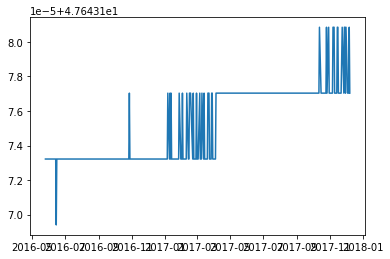

In [226]:
plt.plot(dataset.test_dates[:-14],preds)

In [ ]:
test=Dataset

Original train and test((1609, 12), (403, 12))
X train size (1589, 20, 12)
Y train size: (1589, 1)
X test size: (383, 20, 12)
X test size: (383, 1)


In [229]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = stock
training_set=stock.iloc[:(int(len(stock)*0.8)),3:4].values

In [82]:
dataset_test.shape,dataset_train.shape

((403, 12), (2012, 12))

In [230]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [231]:
X_train.shape

(1198, 60, 1)

In [232]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)



# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017


Epoch 1/100
38/38 [==============================] - 12s 65ms/step - loss: 0.0328
Epoch 2/100
38/38 [==============================] - 3s 72ms/step - loss: 0.0029
Epoch 3/100
38/38 [==============================] - 3s 75ms/step - loss: 0.0028
Epoch 4/100
38/38 [==============================] - 3s 72ms/step - loss: 0.0032
Epoch 5/100
38/38 [==============================] - 3s 77ms/step - loss: 0.0036
Epoch 6/100
38/38 [==============================] - 4s 92ms/step - loss: 0.0021
Epoch 7/100
38/38 [==============================] - 3s 79ms/step - loss: 0.0021
Epoch 8/100
38/38 [==============================] - 3s 82ms/step - loss: 0.0021
Epoch 9/100
38/38 [==============================] - 3s 90ms/step - loss: 0.0023
Epoch 10/100
38/38 [==============================] - 3s 72ms/step - loss: 0.0021
Epoch 11/100
38/38 [==============================] - 3s 74ms/step - loss: 0.0024
Epoch 12/100
38/38 [==============================] - 3s 73ms/step - loss: 0.0022
Epoch 13/100
38/38 [====

KeyboardInterrupt: 

In [233]:
dataset_test=stock.iloc[(int(len(stock)*0.8)):,:]
real_stock_price = dataset_test.Close

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 400):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

X_test.shape


(340, 60, 1)

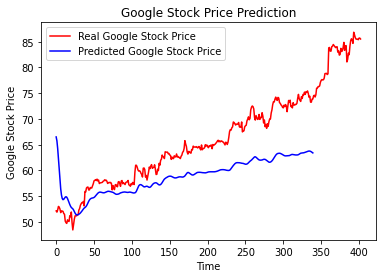

In [234]:
# Visualising the results
plt.plot(real_stock_price.values, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()